In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
from advait_solver_solid_mech import *

(392, 2)


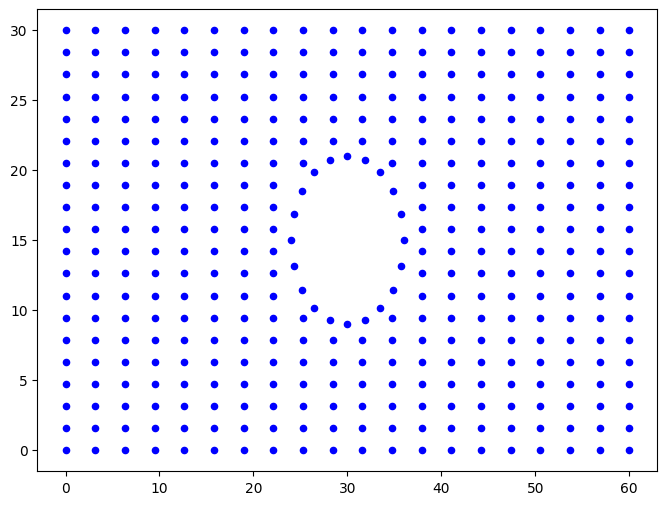

In [2]:
#points for the domain generated in the node_set as:
point_density = 20
hole_nodes = 21
width = 60
height = 30
hole_radius = int(0.1*width)
hole_center = (width/2,height/2)
buffer = 0.3#0.3 # this buffer ensures that the rectangular and circular points are not too close
x_points = np.linspace(0, width, point_density)
y_points = np.linspace(0, height, point_density)
theta = np.linspace(0,2*np.pi, hole_nodes)
hole_points = np.array([hole_center + hole_radius * np.array([np.cos(t), np.sin(t)]) for t in theta[:-1]]) #you need to remove the last theta(2pi)
rectangular_points = np.array([[x, y] for x in x_points for y in y_points])

mask =  np.linalg.norm(rectangular_points - hole_center, axis=1) >= hole_radius + buffer

filtered_points = rectangular_points[mask]
node_set = np.vstack([filtered_points,hole_points])

print(np.shape(node_set))

plt.figure(figsize=(8, 6))
plt.scatter(node_set[:, 0], node_set[:, 1], color='blue', label="Rectangular Points (outside hole)", s=20)
#plt.scatter(hole_points[:, 0], hole_points[:, 1], color='red', label="Hole Boundary Points", s=50)
plt.show()

In [3]:
mesh = Mesh(node_set)
mesh.element_list = []

tri = Delaunay(node_set)
#print(tri.simplices)
for simplex in tri.simplices:
    if (node_set[simplex][0] not in hole_points) or (node_set[simplex][1] not in hole_points) or (node_set[simplex][2] not in hole_points):
        #pass
        mesh.element_list.append(Trielement(node_set[simplex[0]],node_set[simplex[1]],node_set[simplex[2]],simplex[0],simplex[1],simplex[2]))
        #print(simplex)
    #print(node_set[simplex][0])
    #print("")t_node = False,plot_element = True)

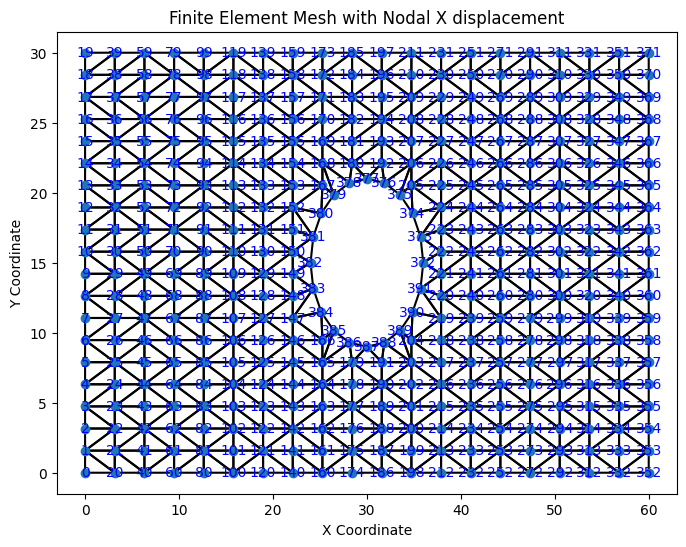

In [21]:
mesh.plot_mesh(plot_node= True,plot_element = False)

In [5]:
num_elements = len(mesh.element_list)
print("Number of elements used in mesh:",num_elements)
print("Number of nodes used in mesh:",mesh.num_nodes)

Number of elements used in mesh: 688
Number of nodes used in mesh: 392


In [6]:
for i, x in enumerate(node_set):
    if x[0] == 0:
        mesh.ebc_x.append(i)
        mesh.ebc_y.append(i)

print("Node set used for application of essential boundary condition at x=0:", mesh.ebc_x)

Node set used for application of essential boundary condition at x=0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [7]:
mesh.calc_global_stiffness()

In [8]:
mesh.reduce_global_stiffness()

In [9]:
right_nodes = []

for i, x in enumerate(node_set):
    if x[0] == width:
        right_nodes.append(i)

print(right_nodes)

[352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371]


In [10]:
force_per_length = 1000 #N/m
nodal_force = height*force_per_length/len(right_nodes)

mesh.force_matrix[mesh.u_nodes[right_nodes]] = nodal_force

In [11]:
mesh.global_displacement = np.linalg.solve(mesh.global_stiffness_matrix,mesh.force_matrix)

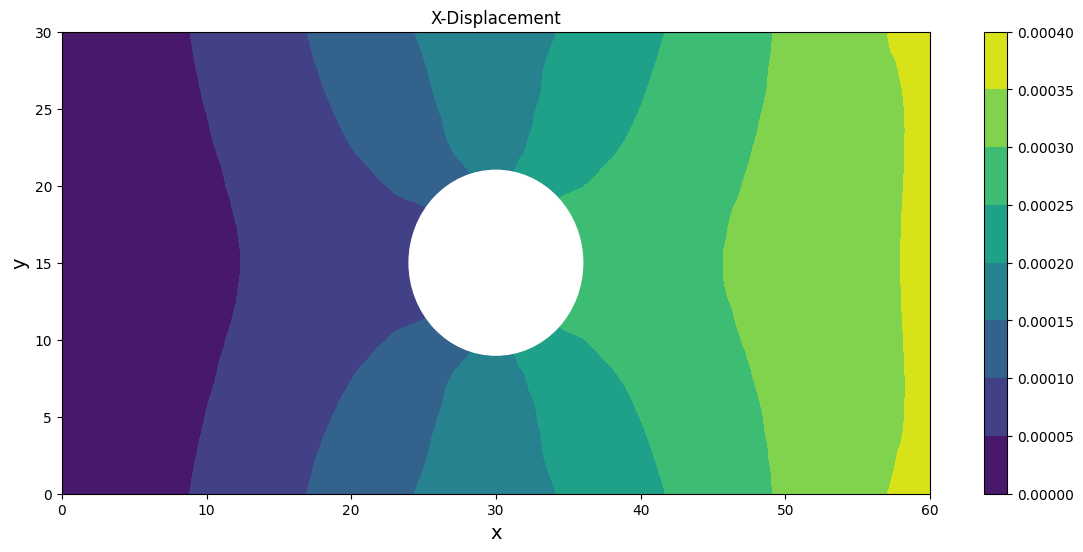

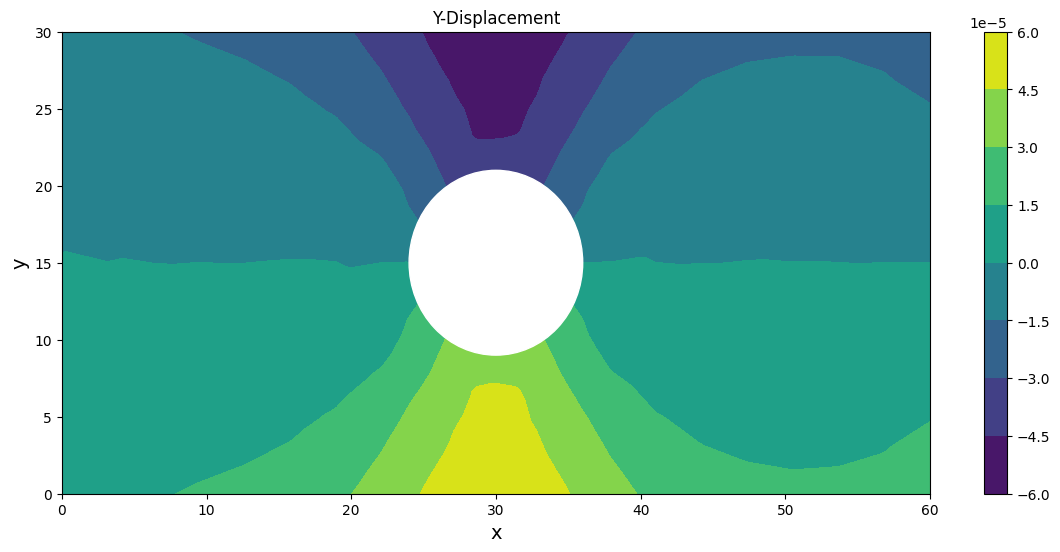

In [35]:
from scipy.interpolate import griddata
x = node_set[:,0]
y = node_set[:,1]

u = np.zeros(len(x)); v = np.zeros(len(x))

for i in range(len(x)):
    u[i] = mesh.global_displacement[2*i]
    v[i] = mesh.global_displacement[2*i+1]

xs, ys = np.meshgrid(np.linspace(min(x), max(x), 200),np.linspace(min(y), max(y), 200))

us = griddata(points=(x, y),values=u, xi=(xs, ys),method='linear') 
vs = griddata(points=(x, y),values=v, xi=(xs, ys),method='linear')

#plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(14, 6))
h = plt.contourf(xs, ys, us)
circle = patches.Circle(hole_center, radius = hole_radius, color = 'w')
plt.gca().add_patch(circle)
cbar = plt.colorbar(h)
cbar.ax.tick_params(labelsize=10)
plt.xlabel('x',fontsize=14); plt.ylabel('y',fontsize=14)
plt.title("X-Displacement")
#plt.plot(x,y,'o', color='red',markersize=8)
plt.show()

plt.figure(figsize=(14, 6))
h = plt.contourf(xs, ys, vs)
cbar = plt.colorbar(h)
circle = patches.Circle(hole_center, radius = hole_radius, color = 'w')
plt.gca().add_patch(circle)
plt.xlabel('x',fontsize=14); plt.ylabel('y',fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.title("Y-Displacement")
#plt.plot(x,y,'o', color='red',markersize=8)
plt.show()

In [34]:
def result(node):
    print(round(mesh.global_displacement[mesh.u_nodes[node]],7))
    print(round(mesh.global_displacement[mesh.v_nodes[node]],7))

NODAL_Q = [{'node':185, "sol":1}, {'node':377, "sol":2 },{'node':372, "sol":3 },{'node':361, "sol":4 }]

for dic in NODAL_Q:
    print("u_x,u_y at point:", dic['sol'])
    result(dic['node'])

u_x,u_y at point: 1
0.0001721
-5.51e-05
u_x,u_y at point: 2
0.0001796
-4.14e-05
u_x,u_y at point: 3
0.0002793
0.0
u_x,u_y at point: 4
0.0003593
9e-07
